## POS tagging using modified Viterbi

### Data Preparation

In [92]:
#Importing libraries
import nltk
nltk.download('treebank')
nltk.download('universal_tagset')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import random
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [44]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [45]:
# first start tagged sentences
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [46]:
#  train and test split of data
random.seed(100)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print("Training set: " ,len(train_set))
print("validation set: ",len(test_set))
print(train_set[:5])

Training set:  3718
validation set:  196
[[('Billings', 'NOUN'), ('*ICH*-3', 'X'), ('were', 'VERB'), ("n't", 'ADV'), ('disclosed', 'VERB'), ('*-1', 'X'), ('for', 'ADP'), ('the', 'DET'), ('small', 'ADJ'), ('account', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-155', 'X'), ('had', 'VERB'), ('been', 'VERB'), ('serviced', 'VERB'), ('*-2', 'X'), ('at', 'ADP'), ('Young', 'NOUN'), ('&', 'CONJ'), ('Rubicam', 'NOUN'), (',', '.'), ('New', 'NOUN'), ('York', 'NOUN'), ('.', '.')], [('CERTIFICATES', 'NOUN'), ('OF', 'ADP'), ('DEPOSIT', 'NOUN'), (':', '.'), ('8.07', 'NUM'), ('%', 'NOUN'), ('one', 'NUM'), ('month', 'NOUN'), (';', '.'), ('8.06', 'NUM'), ('%', 'NOUN'), ('two', 'NUM'), ('months', 'NOUN'), (';', '.'), ('8.04', 'NUM'), ('%', 'NOUN'), ('three', 'NUM'), ('months', 'NOUN'), (';', '.'), ('7.95', 'NUM'), ('%', 'NOUN'), ('six', 'NUM'), ('months', 'NOUN'), (';', '.'), ('7.88', 'NUM'), ('%', 'NOUN'), ('one', 'NUM'), ('year', 'NOUN'), ('.', '.')], [('He', 'PRON'), ('said', 'VERB'), ('0', 'X'), ('th

In [47]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95639

In [48]:
# get tokens  from the train set
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Billings',
 '*ICH*-3',
 'were',
 "n't",
 'disclosed',
 '*-1',
 'for',
 'the',
 'small',
 'account']

In [49]:
# get the POS tags
train_pos_tags = [pair[1] for pair in train_tagged_words]
train_pos_tags[:10]

['NOUN', 'X', 'VERB', 'ADV', 'VERB', 'X', 'ADP', 'DET', 'ADJ', 'NOUN']

In [50]:
# transform the vocabulary to a set
training_vocabulary_set = set(tokens)
len(training_vocabulary_set)

12099

In [51]:
# POS tags to a set
train_pos_tag_set = set(train_pos_tags)
len(train_pos_tag_set)

12

In [52]:
print(train_pos_tag_set)

{'DET', 'CONJ', 'ADV', '.', 'PRT', 'NUM', 'ADJ', 'ADP', 'X', 'NOUN', 'PRON', 'VERB'}


### Build the vanilla Viterbi based POS tagger

In [53]:
# uting P(w/t) and storing in T x V matrix
t = len(train_pos_tag_set)
v = len(training_vocabulary_set)
w_given_t = np.zeros((t, v))

In [54]:
# compute word given tag: Emission Probability

def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [55]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [56]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(train_pos_tag_set), len(train_pos_tag_set)), dtype='float32')
for i, t1 in enumerate(list(train_pos_tag_set)):
    for j, t2 in enumerate(list(train_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

tags_matrix


array([[5.66879753e-03, 4.82450851e-04, 1.30261732e-02, 1.74888428e-02,
        2.41225425e-04, 2.21927390e-02, 2.05403447e-01, 9.16656572e-03,
        4.55916040e-02, 6.37196958e-01, 3.61838145e-03, 3.99228074e-02],
       [1.19036593e-01, 4.63177392e-04, 5.46549335e-02, 3.47383060e-02,
        5.09495148e-03, 4.21491414e-02, 1.16257526e-01, 5.46549335e-02,
        7.87401572e-03, 3.50162119e-01, 5.92867061e-02, 1.55627608e-01],
       [6.81515932e-02, 6.98138308e-03, 8.01196843e-02, 1.36303186e-01,
        1.46276597e-02, 3.29122357e-02, 1.29654258e-01, 1.18351065e-01,
        2.32712757e-02, 3.02526597e-02, 1.46276597e-02, 3.44747335e-01],
       [1.73190877e-01, 5.88076860e-02, 5.24331108e-02, 9.23864245e-02,
        2.33435095e-03, 8.16124976e-02, 4.40833196e-02, 9.03214216e-02,
        2.73837317e-02, 2.23289639e-01, 6.54516071e-02, 8.86155516e-02],
       [1.00260414e-01, 2.27864576e-03, 1.00911455e-02, 4.36197929e-02,
        1.95312500e-03, 5.79427071e-02, 8.39843750e-02, 2.14

In [57]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(train_pos_tag_set), index=list(train_pos_tag_set))
tags_df

,DET,CONJ,ADV,.,PRT,NUM,ADJ,ADP,X,NOUN,PRON,VERB
DET,0.005669,0.000482,0.013026,0.017489,0.000241,0.022193,0.205403,0.009167,0.045592,0.637197,0.003618,0.039923
CONJ,0.119037,0.000463,0.054655,0.034738,0.005095,0.042149,0.116258,0.054655,0.007874,0.350162,0.059287,0.155628
ADV,0.068152,0.006981,0.080120,0.136303,0.014628,0.032912,0.129654,0.118351,0.023271,0.030253,0.014628,0.344747
.,0.173191,0.058808,0.052433,0.092386,0.002334,0.081612,0.044083,0.090321,0.027384,0.223290,0.065452,0.088616
PRT,0.100260,0.002279,0.010091,0.043620,0.001953,0.057943,0.083984,0.021484,0.013021,0.250326,0.018229,0.396810
NUM,0.002942,0.013828,0.002648,0.115916,0.027361,0.185054,0.032657,0.036481,0.210062,0.353339,0.001471,0.018241
ADJ,0.004773,0.016623,0.004773,0.065010,0.010698,0.020573,0.065010,0.077847,0.021066,0.700625,0.000658,0.012344
ADP,0.325492,0.000855,0.013045,0.039991,0.001497,0.062981,0.107036,0.017429,0.034752,0.319290,0.069076,0.008554
X,0.054119,0.010696,0.025862,0.162516,0.184547,0.002874,0.016922,0.143838,0.074234,0.063059,0.055715,0.205619
NOUN,0.013310,0.042556,0.016920,0.240820,0.044561,0.009554,0.012216,0.176312,0.028699,0.263684,0.004850,0.146519


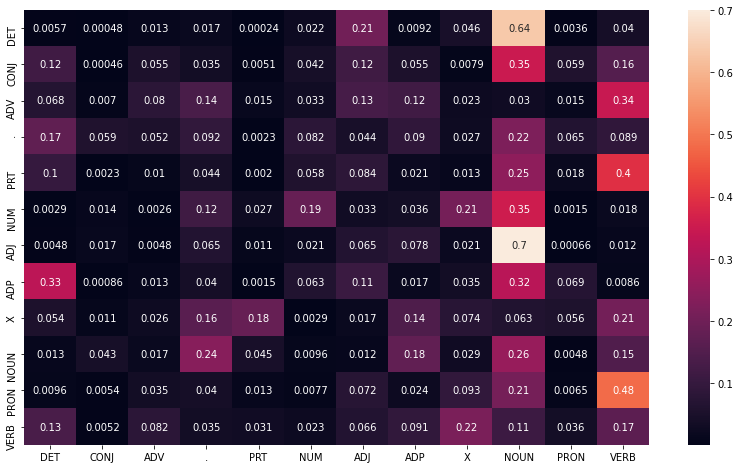

In [58]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(14, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

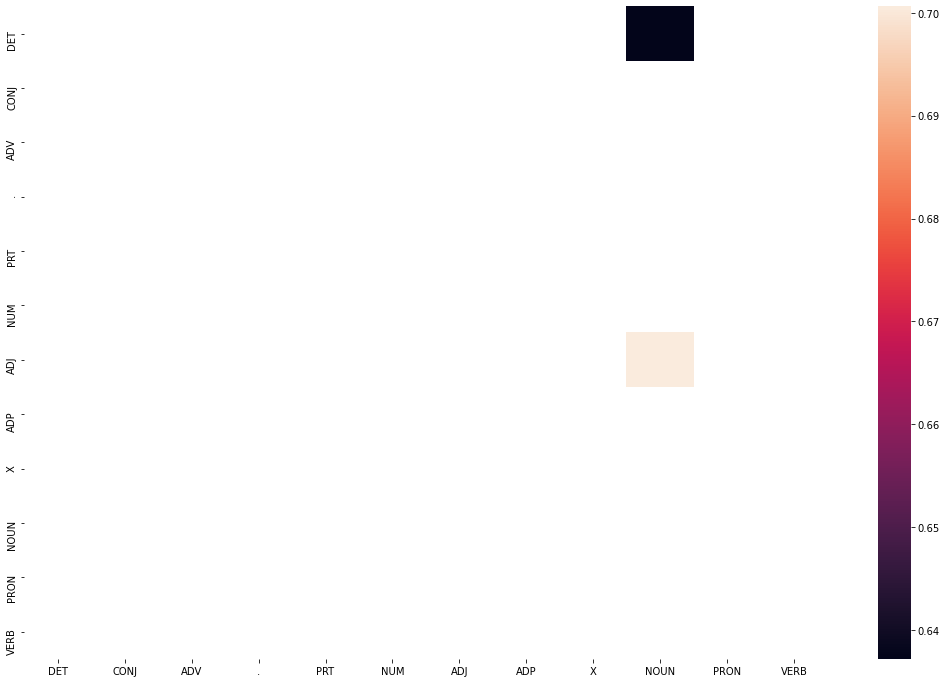

In [59]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [60]:
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [61]:

random.seed(100)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('The', 'DET'),
  ('minimum-wage', 'NOUN'),
  ('bill', 'NOUN'),
  ('worked', 'VERB'),
  ('out', 'PRT'),
  ('*', 'X'),
  ('by', 'ADP'),
  ('Congress', 'NOUN'),
  ('and', 'CONJ'),
  ('Bush', 'NOUN'),
  ('won', 'VERB'),
  ('easy', 'ADJ'),
  ('approval', 'NOUN'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('House', 'NOUN'),
  ('.', '.')],
 [('On', 'ADP'),
  ('the', 'DET'),
  ('receiving', 'VERB'),
  ('end', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('message', 'NOUN'),
  ('were', 'VERB'),
  ('*T*-1', 'X'),
  ('officials', 'NOUN'),
  ('from', 'ADP'),
  ('giants', 'NOUN'),
  ('like', 'ADP'),
  ('Du', 'NOUN'),
  ('Pont', 'NOUN'),
  ('and', 'CONJ'),
  ('Maytag', 'NOUN'),
  (',', '.'),
  ('along', 'ADP'),
  ('with', 'ADP'),
  ('lesser', 'ADJ'),
  ('knowns', 'NOUN'),
  ('like', 'ADP'),
  ('Trojan', 'NOUN'),
  ('Steel', 'NOUN'),
  ('and', 'CONJ'),
  ('the', 'DET'),
  ('Valley', 'NOUN'),
  ('Queen', 'NOUN'),
  ('Cheese', 'NOUN'),
  ('Factory', 'NOUN'),
  ('.', '.')],
 [('In', 'ADP'),
  ('the', 'DE

In [62]:
#Test accuracy of Vanilla Viterbi Algorithm algorithm


start = time.time()

# tag the test sentences
tagged_seq = Viterbi(test_tagged_words)

end = time.time()
difference = end-start

print("duration of Vanilla Viterbi Algorithm: ", difference)

check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

vanilla_viterbi_accuracy = len(check)/len(tagged_seq)

print("Accuracy of the Vanilla Viterbi Algorithm: ", vanilla_viterbi_accuracy)

duration of Vanilla Viterbi Algorithm:  40.30942177772522
Accuracy of the Vanilla Viterbi Algorithm:  0.9145299145299145


In [63]:
#incorrect tag cases in the test set
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
incorrect_tagged_cases

10


[[('The', 'DET'), (('minimum-wage', 'DET'), ('minimum-wage', 'NOUN'))],
 [('and', 'CONJ'), (('Maytag', 'DET'), ('Maytag', 'NOUN'))],
 [('with', 'ADP'), (('lesser', 'DET'), ('lesser', 'ADJ'))],
 [('lesser', 'ADJ'), (('knowns', 'DET'), ('knowns', 'NOUN'))],
 [('like', 'ADP'), (('Trojan', 'DET'), ('Trojan', 'NOUN'))],
 [('Valley', 'NOUN'), (('Queen', 'DET'), ('Queen', 'NOUN'))],
 [('Queen', 'NOUN'), (('Cheese', 'DET'), ('Cheese', 'NOUN'))],
 [('to', 'PRT'), (('buffet', 'NOUN'), ('buffet', 'VERB'))],
 [('from', 'ADP'), (('cycles', 'DET'), ('cycles', 'NOUN'))],
 [('in', 'ADP'), (('rankings', 'DET'), ('rankings', 'NOUN'))]]

### Solve the problem of unknown words

In [64]:
test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - training_vocabulary_set)
print("Total Unknown words :", len(unknown_words),"\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 9 

Unknown Words : ['rankings', 'knowns', 'cycles', 'Maytag', 'Queen', 'minimum-wage', 'Trojan', 'Cheese', 'lesser']


In [65]:
def ViterbiForUnknownWords(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm for unknown words
            if word not in training_vocabulary_set:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [66]:
# tagging the test sentences
start = time.time()

unknown_word_tagged_seq = ViterbiForUnknownWords(test_tagged_words)

end = time.time()
difference = end-start

print("duration for viterbi algorithm for unknown words: ", difference)

# accuracy
unknown_word_check = [i for i, j in zip(unknown_word_tagged_seq, test_run_base) if i == j]

optimized_viterbi_accuracy = len(unknown_word_check)/len(unknown_word_tagged_seq)

print("accuracy of the viterbi algorithm for unknown words: ", optimized_viterbi_accuracy)

duration for viterbi algorithm for unknown words:  40.78337359428406
accuracy of the viterbi algorithm for unknown words:  0.9572649572649573


There's is a increase in the accuracy of 2% percent by using modified viterbi algorithm for unknown words than the vanilla viterbi algorithm. 

1.  unigram tagger for POS tagging

In [67]:
# Unigram Tagger
unigram_tagger = nltk.UnigramTagger(train_set)

start = time.time()

unigram_tagger_accuracy = unigram_tagger.evaluate(test_set)

end = time.time()
difference = end-start

print("duration for Unigram Tagger: ", difference)
print("The accuracy of the Unigram Tagger is: ", unigram_tagger_accuracy)

duration for Unigram Tagger:  0.00943136215209961
The accuracy of the Unigram Tagger is:  0.9102640460591622


3. Unigram + Regex POS tagger

In [68]:
 patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

In [69]:
# Unigram + rule based tagger

rule_tagger = nltk.RegexpTagger(patterns)
start = time.time()
# unigram tagger + the rule-based tagger
unigram_rule_based_tagger = nltk.UnigramTagger(train_set, backoff = rule_tagger)

accuracy_unigram_rule_based_tagger = unigram_rule_based_tagger.evaluate(test_set)
end = time.time()
difference = end-start
print("The duration of the unigram tagger + the rule-based tagger is -", difference)
print("The accuracy of the unigram tagger + the rule-based tagger is -", accuracy_unigram_rule_based_tagger)


The duration of the unigram tagger + the rule-based tagger is - 2.6878435611724854
The accuracy of the unigram tagger + the rule-based tagger is - 0.9598967639467937


In [70]:
# Bigram Tagger
bigram_tagger = nltk.BigramTagger(train_set, backoff = unigram_rule_based_tagger)

start = time.time()

bigram_tagger_accuracy = bigram_tagger.evaluate(test_set)

end = time.time()
difference = end-start

print("duration for bigram Tagger: ", difference)
print("The accuracy of the bigram Tagger is: ", bigram_tagger_accuracy)

duration for bigram Tagger:  0.05582547187805176
The accuracy of the bigram Tagger is:  0.9610879491760969


In [71]:
#bigram + rule based tagger 

start = time.time()
# bigram tagger + the rule-based tagger
bigram_rule_based_tagger = nltk.BigramTagger(train_set, backoff = rule_tagger)

accuracy_bigram_rule_based_tagger = bigram_rule_based_tagger.evaluate(test_set)
end = time.time()
difference = end-start
print("The duration of the bigram tagger + the rule-based tagger is -", difference)
print("The accuracy of the bigram tagger + the rule-based tagger is -", accuracy_bigram_rule_based_tagger)

The duration of the bigram tagger + the rule-based tagger is - 2.9903018474578857
The accuracy of the bigram tagger + the rule-based tagger is - 0.9374627754615843


In [72]:
# trigram tagger

trigram_tagger = nltk.TrigramTagger(train_set,backoff=bigram_rule_based_tagger)

start = time.time()

accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)

end = time.time()
difference = end-start


print("duration for Trigram Tagger: ", difference)

print("The accuracy of the Trigram Tagger: ", accuracy_trigram_tagger)

duration for Trigram Tagger:  0.07103514671325684
The accuracy of the Trigram Tagger:  0.9376613063331348


In [73]:

def trigram_tagger_ruled_tagger(word, train_set = train_set):
    
    trigram_rule_based_tagger = nltk.TrigramTagger(train_set, backoff = rule_tagger)
    return trigram_rule_based_tagger.tag_sents([[(word)]])


In [74]:

def trigram_brigram_tagger(word, train_set = train_set):
    
    trigram_brigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_rule_based_tagger)
    return trigram_brigram_tagger.tag_sents([[(word)]])


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [75]:
def ViterbiBackedupTrigramRuleBasedTagger(words, train_bag = train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the trigram tagger backed up by the rule based tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in training_vocabulary_set:
            unknown_word_tag = trigram_tagger_ruled_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [76]:
def ViterbiBackedupTrigramBigramTagger(words, train_bag = train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the trigram tagger backed up by the bigram tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in training_vocabulary_set:
            unknown_word_tag = trigram_brigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [77]:
# tagging the test sentences
start = time.time()

Viterbi_backed_Trigram_rule_seq = ViterbiBackedupTrigramRuleBasedTagger(test_tagged_words)

end = time.time()
difference = end-start

print("duration for viterbi + trigram rule based  for unknown words: ", difference)

# accuracy
unknown_word_check = [i for i, j in zip(Viterbi_backed_Trigram_rule_seq, test_run_base) if i == j]

Viterbi_backed_Trigram_rule_accuracy = len(unknown_word_check)/len(Viterbi_backed_Trigram_rule_seq)

print("accuracy of the viterbi + trigram rule based for unknown words: ", Viterbi_backed_Trigram_rule_accuracy)

duration for viterbi + trigram rule based  for unknown words:  63.34251356124878
accuracy of the viterbi + trigram rule based for unknown words:  0.9658119658119658


In [78]:
# tagging the test sentences
start = time.time()

Viterbi_Trigram_Bigram_rule_seq = ViterbiBackedupTrigramBigramTagger(test_tagged_words)

end = time.time()
difference = end-start

print("duration for viterbi + trigram rule based  for unknown words: ", difference)

# accuracy
unknown_word_check = [i for i, j in zip(Viterbi_Trigram_Bigram_rule_seq, test_run_base) if i == j]

Viterbi_Trigram_Bigram_rule_accuracy = len(unknown_word_check)/len(Viterbi_Trigram_Bigram_rule_seq)

print("accuracy of the viterbi + trigram + Bigram rule based for unknown words: ", Viterbi_Trigram_Bigram_rule_accuracy)

duration for viterbi + trigram rule based  for unknown words:  53.72558116912842
accuracy of the viterbi + trigram + Bigram rule based for unknown words:  0.9658119658119658


#### Evaluating tagging accuracy

In [79]:
tagging_acccuracy = [['Vanilla Viterbi', vanilla_viterbi_accuracy*100], 
                  ['Optimised   Vanilla Viterbi', optimized_viterbi_accuracy*100],
                  ['Unigram Tagger', unigram_tagger_accuracy*100],
                  ['Unigram + Rule based Tagger', accuracy_unigram_rule_based_tagger*100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_rule_based_tagger*100],
                  ['Trigram Tagger + Bigram tagger', accuracy_trigram_tagger*100],
                  ['Viterbi + Trigram_tagger', Viterbi_backed_Trigram_rule_accuracy*100],
                  ['Viterbi + Trigram Tagger + Bigram tagger', Viterbi_Trigram_Bigram_rule_accuracy*100]]

tagging_acccuracy_df = pd.DataFrame(tagging_acccuracy, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

tagging_acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

tagging_acccuracy_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,91.452991
Optimised Vanilla Viterbi,95.726496
Unigram Tagger,91.026405
Unigram + Rule based Tagger,95.989676
Bigram Tagger + Unigram_tagger,93.746278
Trigram Tagger + Bigram tagger,93.766131
Viterbi + Trigram_tagger,96.581197
Viterbi + Trigram Tagger + Bigram tagger,96.581197


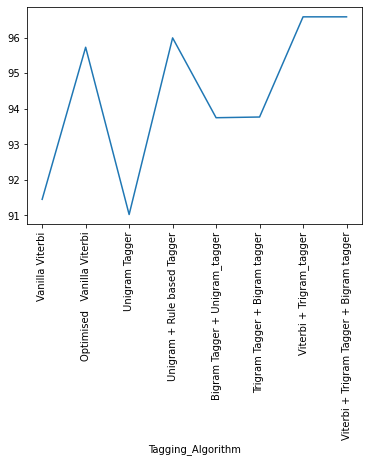

In [80]:
tagging_acccuracy_df.plot.line(rot = 90, legend = False)


In [85]:
test_sentences = ["Android is a mobile operating system developed by Google.",
"Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."]

In [93]:
test_tokenized_sentences = [word_tokenize(sent) for sent in test_sentences]
test_corpus_pos_tags = nltk.pos_tag_sents(test_tokenized_sentences, tagset = 'universal')
test_corpus_pos_tags


[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [99]:
# list of untagged words from the  test stentences
test_tagged_words = [tup[0] for sent in test_corpus_pos_tags for tup in sent]


# list of tagged words from the  test stentences
test_run_base = [tup for sent in test_corpus_pos_tags for tup in sent]

test_tagged_words


['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

In [111]:
# tagging the test sentences
Viterbi_test_tagged_seq = Viterbi(test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(Viterbi_test_tagged_seq, test_run_base) if i == j]

vanilla_viterbi_accuracy_test_data = len(sample_test_check)/len(Viterbi_test_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm on the sample test data is -", vanilla_viterbi_accuracy_test_data)

The accuracy of the Vanilla Viterbi Algorithm on the sample test data is - 0.7458563535911602


In [112]:
# tagging the test sentences
Viterbi_optimised_test_tagged_seq = ViterbiForUnknownWords(test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(Viterbi_optimised_test_tagged_seq, test_run_base) if i == j]

optimised_viterbi_accuracy_test_data = len(sample_test_check)/len(Viterbi_optimised_test_tagged_seq)

print("The accuracy of the optimised Viterbi Algorithm on the  test data:", optimised_viterbi_accuracy_test_data)

The accuracy of the optimised Viterbi Algorithm on the  test data: 0.856353591160221


In [118]:
# tagging the test sentences
Viterbi_trigram_bigram_test_tagged_seq = ViterbiBackedupTrigramBigramTagger(test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(Viterbi_trigram_bigram_test_tagged_seq, test_run_base) if i == j]

viterbi_trigram_bigram_accuracy_test_data = len(sample_test_check)/len(Viterbi_trigram_bigram_test_tagged_seq)

print("The accuracy of the viterbi trigram Bigram Algorithm on the test data:", viterbi_trigram_bigram_accuracy_test_data)

The accuracy of the viterbi trigram Bigram Algorithm on the test data: 0.9281767955801105


In [119]:
acccuracy_test_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy_test_data*100], 
                  ['Optimized Vanilla Viterbi', optimised_viterbi_accuracy_test_data*100], 
                  ['Viterbi + Trigram Bigram tagger', viterbi_trigram_bigram_accuracy_test_data*100]]

sample_test_data_acccuracy_df = pd.DataFrame(acccuracy_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

sample_test_data_acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

sample_test_data_acccuracy_df


,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,74.585635
Optimized Vanilla Viterbi,85.635359
Viterbi + Trigram Bigram tagger,92.817680


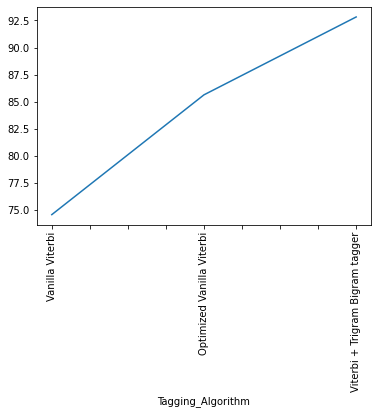

In [120]:
sample_test_data_acccuracy_df.plot.line(rot = 90, legend = False)


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

### **CASE 1**

In [137]:
test_sentence_2='Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
test_words = word_tokenize(test_sentence_2)
Viterbi_test_tagged_seq_2 = Viterbi(test_words)

print("Tagging sequence with Vanilla_Viterbi -\n\n", Viterbi_test_tagged_seq_2)

print('\n')

print('*'*100)

Viterbi_optimised_test_tagged_seq_2 = ViterbiForUnknownWords(test_words)
print("Tagging sequence with Optimised Viterbi -\n\n", Viterbi_optimised_test_tagged_seq_2)

print('\n')

print('*'*100)

Viterbi_trigram_bigram_test_tagged_seq_2 = ViterbiBackedupTrigramBigramTagger(test_words)
print("Tagging sequence with Viterbi backed trigram + bigram -\n\n", Viterbi_trigram_bigram_test_tagged_seq_2)

print('\n')

print('*'*100)



Tagging sequence with Vanilla_Viterbi -

 [('Android', 'DET'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'DET'), ('worldwide', 'DET'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.')]


****************************************************************************************************
Tagging sequence with Optimised Viterbi -

 [('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.')]


****************************************************************************************************
Tagging sequence with Viterbi backed trigram + bigram -

 [('Android', 'NOUN'), ('has', '

In [138]:
tags_correction_df_2 = pd.DataFrame(columns = ['vanilla_viterbi', 'viterbi_trigram_corrections'])
tags_correction_df_2 = tags_correction_df_2.fillna(0)

tags_correction_df_2.vanilla_viterbi = [tup for tup in Viterbi_test_tagged_seq_2]
tags_correction_df_2.viterbi_trigram_corrections = [tup for tup in Viterbi_trigram_bigram_test_tagged_seq_2]

tags_correction_df_2


,vanilla_viterbi,viterbi_trigram_corrections
0,"(Android, DET)","(Android, NOUN)"
1,"(has, VERB)","(has, VERB)"
2,"(been, VERB)","(been, VERB)"
3,"(the, DET)","(the, DET)"
4,"(best-selling, ADJ)","(best-selling, ADJ)"
5,"(OS, DET)","(OS, NOUN)"
6,"(worldwide, DET)","(worldwide, NOUN)"
7,"(on, ADP)","(on, ADP)"
8,"(smartphones, DET)","(smartphones, VERB)"
9,"(since, ADP)","(since, ADP)"


### CASE 2

In [132]:
test_sentence_4='Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
test_words = word_tokenize(test_sentence_4)
Viterbi_test_tagged_seq_4 = Viterbi(test_words)


print("Tagging sequence with Vanilla_Viterbi -\n\n", Viterbi_test_tagged_seq_4)

print('\n')

print('*'*100)

Viterbi_optimised_test_tagged_seq_4 = ViterbiForUnknownWords(test_words)
print("Tagging sequence with Optimised Viterbi -\n\n", Viterbi_optimised_test_tagged_seq_4)

print('\n')

print('*'*100)

Viterbi_trigram_bigram_test_tagged_seq_4 = ViterbiBackedupTrigramBigramTagger(test_words)
print("Tagging sequence with Viterbi backed trigram + bigram -\n\n", Viterbi_trigram_bigram_test_tagged_seq_4)

print('\n')

print('*'*100)

Tagging sequence with Vanilla_Viterbi -

 [('Twitter', 'DET'), ('is', 'VERB'), ('an', 'DET'), ('online', 'DET'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'DET'), ('with', 'ADP'), ('messages', 'DET'), ('known', 'ADJ'), ('as', 'ADP'), ('tweets', 'DET'), ('.', '.')]


****************************************************************************************************
Tagging sequence with Optimised Viterbi -

 [('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'NOUN'), ('with', 'ADP'), ('messages', 'DET'), ('known', 'ADJ'), ('as', 'ADP'), ('tweets', 'DET'), ('.', '.')]


**********************************************

In [133]:
tags_correction_df_4 = pd.DataFrame(columns = ['vanilla_viterbi', 'viterbi_trigram_corrections'])
tags_correction_df_4 = tags_correction_df_4.fillna(0)

tags_correction_df_4.vanilla_viterbi = [tup for tup in Viterbi_test_tagged_seq_4]
tags_correction_df_4.viterbi_trigram_corrections = [tup for tup in Viterbi_trigram_bigram_test_tagged_seq_4]

tags_correction_df_4


,vanilla_viterbi,viterbi_trigram_corrections
0,"(Twitter, DET)","(Twitter, NOUN)"
1,"(is, VERB)","(is, VERB)"
2,"(an, DET)","(an, DET)"
3,"(online, DET)","(online, NOUN)"
4,"(news, NOUN)","(news, NOUN)"
5,"(and, CONJ)","(and, CONJ)"
6,"(social, ADJ)","(social, ADJ)"
7,"(networking, NOUN)","(networking, NOUN)"
8,"(service, NOUN)","(service, NOUN)"
9,"(on, ADP)","(on, ADP)"


### CASE 3

In [129]:
test_sentence_6='The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
test_words = word_tokenize(test_sentence_6)
Viterbi_test_tagged_seq_6 = Viterbi(test_words)

print("Tagging sequence with Vanilla_Viterbi -\n\n", Viterbi_test_tagged_seq)

print('\n')

print('*'*100)

Viterbi_optimised_test_tagged_seq_6 = ViterbiForUnknownWords(test_words)
print("Tagging sequence with Optimised Viterbi -\n\n", Viterbi_optimised_test_tagged_seq)

print('\n')

print('*'*100)

Viterbi_trigram_bigram_test_tagged_seq_6 = ViterbiBackedupTrigramBigramTagger(test_words)
print("Tagging sequence with Viterbi backed trigram + bigram -\n\n", Viterbi_trigram_bigram_test_tagged_seq)

print('\n')

print('*'*100)



Tagging sequence with Vanilla_Viterbi -

 [('The', 'DET'), ('2018', 'DET'), ('FIFA', 'DET'), ('World', 'NOUN'), ('Cup', 'DET'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'DET'), ('FIFA', 'DET'), ('World', 'NOUN'), ('Cup', 'DET'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'DET'), ('contested', 'DET'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


****************************************************************************************************
Tagging sequence with Optimised Viterbi -

 [('The', 'DET'), ('2018', 'NOUN'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NOUN'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'NOUN'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


*********************

In [131]:
tags_correction_df_6 = pd.DataFrame(columns = ['vanilla_viterbi', 'viterbi_trigram_corrections'])
tags_correction_df_6 = tags_correction_df_6.fillna(0)

tags_correction_df_6.vanilla_viterbi = [tup for tup in Viterbi_test_tagged_seq_6]
tags_correction_df_6.viterbi_trigram_corrections = [tup for tup in Viterbi_trigram_bigram_test_tagged_seq_6]

tags_correction_df_6


,vanilla_viterbi,viterbi_trigram_corrections
0,"(The, DET)","(The, DET)"
1,"(2018, DET)","(2018, NUM)"
2,"(FIFA, DET)","(FIFA, NOUN)"
3,"(World, NOUN)","(World, NOUN)"
4,"(Cup, DET)","(Cup, NOUN)"
5,"(is, VERB)","(is, VERB)"
6,"(the, DET)","(the, DET)"
7,"(21st, DET)","(21st, NUM)"
8,"(FIFA, DET)","(FIFA, NOUN)"
9,"(World, NOUN)","(World, NOUN)"
